# Genesis4 Particles

This shows examples of the various ways to input particle data into Genesis4.

In [1]:
import logging

from genesis.version4.genesis4 import Genesis4Python
from genesis.version4.input import (
    Genesis4Input,
    Line,
    Beam,
    Drift,
    Lattice,
    MainInput,
    ProfileArray,
    ProfileGauss,
    Reference,
    Setup,
    Time,
    Track,
    Write,
)
import os
import numpy as np
from scipy.constants import c
from math import sqrt, pi
import matplotlib.pyplot as plt

logging.basicConfig()
# logging.getLogger("genesis").setLevel("DEBUG")

%config InlineBackend.figure_format = 'retina'

# Lattice

Create a simple drift lattice

In [2]:
D1 = Drift(L=1)
lattice = Lattice(elements={"D1": D1, "LAT": Line([D1])})

# `profile_gauss`

This profile will make a Gaussian distribition. Here we do some calculations to make the correct bunch length for a given bunch charge to provide a peak current.

In [3]:
PEAK_CURRENT = 1000
BUNCH_CHARGE = 100e-12
SIGMA_T = BUNCH_CHARGE / (sqrt(2 * pi) * PEAK_CURRENT)
SIGMA_Z = SIGMA_T * c
SLEN = 6 * SIGMA_Z
S0 = 3 * SIGMA_Z
SIGMA_T, SIGMA_Z, SLEN

(3.989422804014327e-14, 1.1959988684167075e-05, 7.175993210500245e-05)

In [4]:
main = MainInput(
    namelists=[
        Setup(
            rootname="drift_test",
            # lattice="LATFILE",
            beamline="LAT",
            gamma0=1000,
            lambda0=1e-07,
            delz=0.026,
            seed=123456,
            npart=128,
        ),
        Time(slen=SLEN),
        ProfileGauss(
            label="beamcurrent",
            c0=PEAK_CURRENT,
            s0=S0,
            sig=SIGMA_Z,
        ),
        Beam(
            gamma=1000,
            delgam=1,
            current=Reference("beamcurrent"),
        ),
        Track(zstop=1),
        Write(beam="end"),
    ],
)

input = Genesis4Input(
    main=main,
    lattice=lattice,
)
G = Genesis4Python(input=input, verbose=True)
output = G.run()

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpnxp85kal
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpnxp85kal
/Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpnxp85kal/genesis.lat /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpnxp85kal/input.in


In [5]:
G.input.main.get_setup().delz
G.input

Genesis4Input(main=MainInput(namelists=[Setup(rootname='drift_test',
    beamline='LAT',
    gamma0=1000,
    lambda0=1e-07,
    delz=0.026,
    seed=123456,
    npart=128), Time(slen=7.175993210500245e-05), ProfileGauss(label='beamcurrent',
    c0=1000,
    s0=3.5879966052501225e-05,
    sig=1.1959988684167075e-05), Beam(gamma=1000,
    delgam=1,
    current=Reference(label='beamcurrent')), Track(zstop=1), Write(beam='end')], filename=None), lattice=Lattice(elements={"D1": Drift(L=1, label='D1'),
    "LAT": Line(elements=[Drift(L=1, label='D1')],
    label='LAT')}), beamline=None, lattice_name=None, seed=None, source_path=PosixPath('.'), output_path=None, lattice_filename='genesis.lat', input_filename='input.in')

In [6]:
print(G.output.run.output_log)

---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Fri Jan 26 11:55:20 2024

MPI-Comm Size: 1 node

info message: adding parameter 'lattice' to &setup
Parsing lattice file...
Setting up time window of 71.8 microns with 718 sample points...
Adding profile with label: beamcurrent
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 718 slices for a time window of 71.8 microns
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
Writing output file...

Core Simulation done.
Diagnostic::~Diagnostic()
End of Track
Writing particle distribution to file: end.par.h5 ...

Program is terminating...
Ending Time: Fri Jan 26 11:55:20 2024
Total Wall Clock Time: 0.167266 seconds
-------------------------------------



<ParticleGroup with 91904 particles at 0x105c3cfe0>

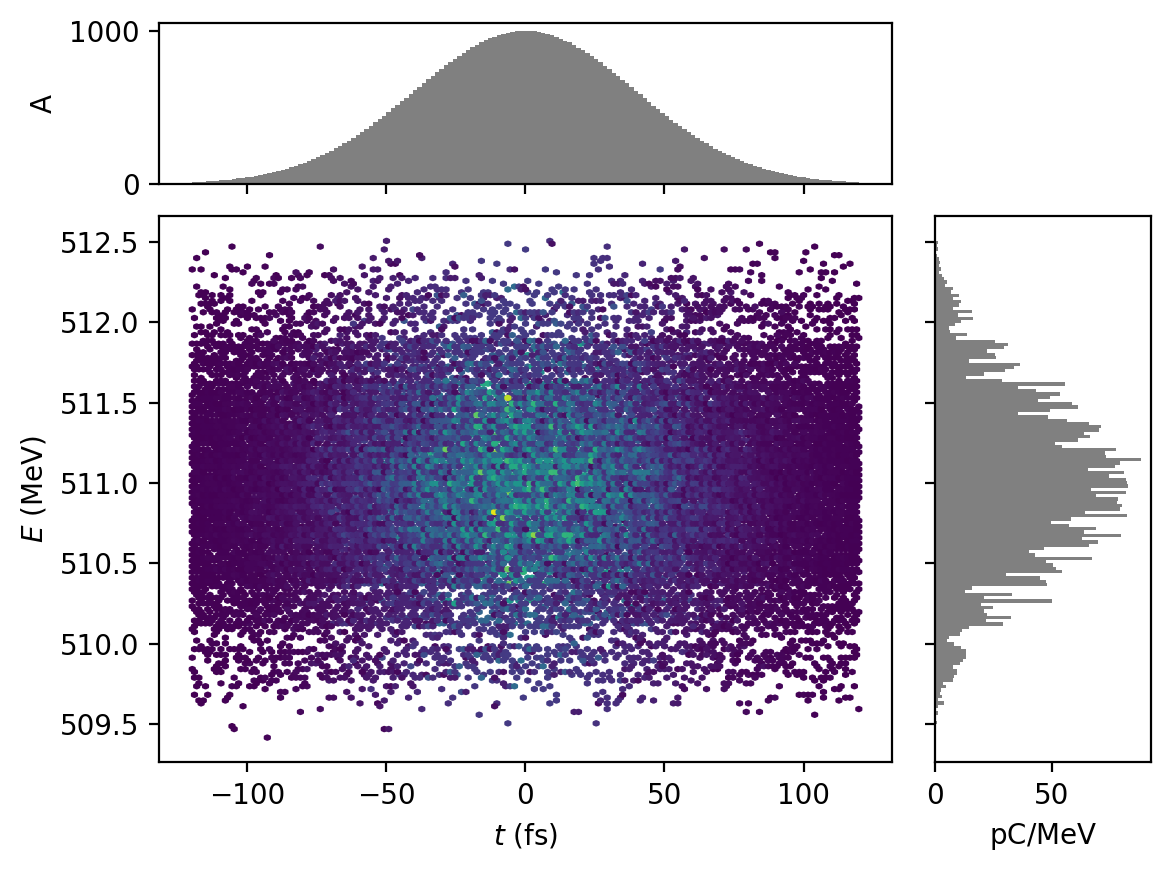

In [7]:
output.load_particles()
P1 = output.particles["end"]
P1.drift_to_z()
P1.plot("t", "energy")
P1

In [8]:
output.particles["end"]

<ParticleGroup with 91904 particles at 0x105c3cfe0>

Check the charge

In [9]:
P1.charge

9.973150081144012e-11

# `profile_file`

LUME-Genesis automatically makes an HDF5 file with `ProfileArray`.

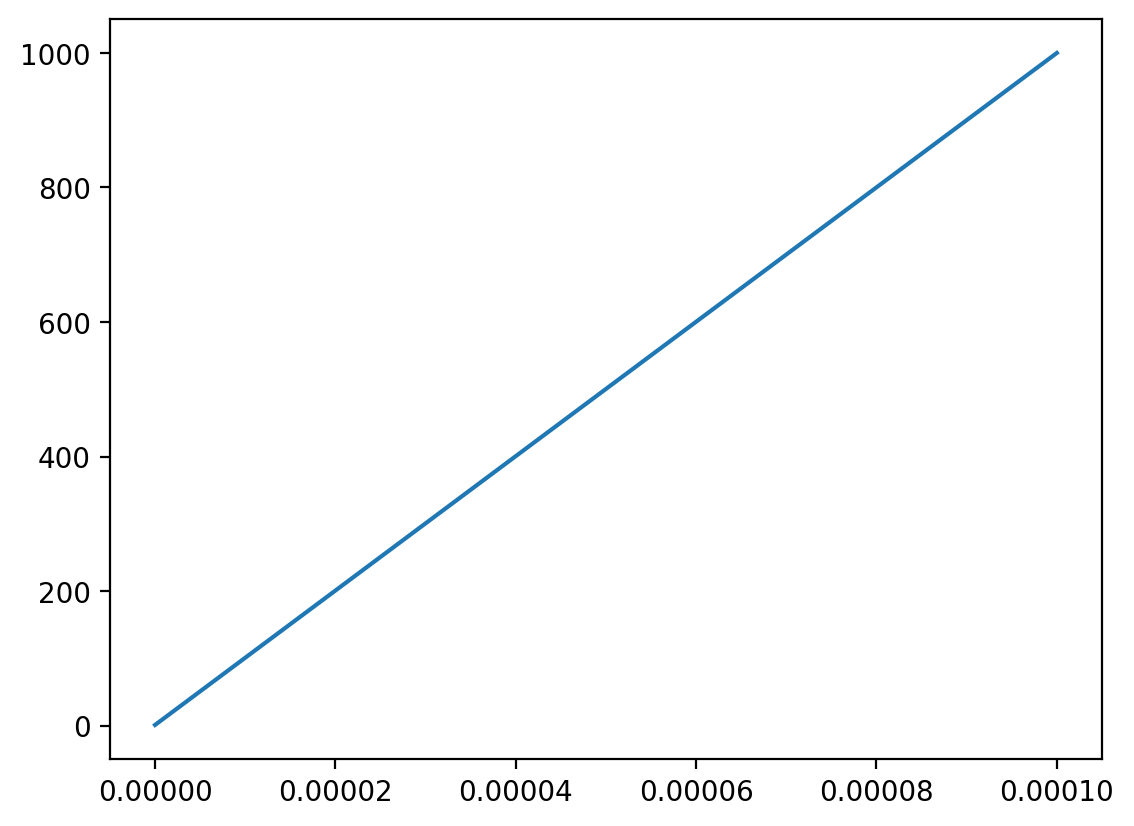

In [10]:
NPTS = 100
SLEN = 100e-6
S = np.linspace(0, SLEN, NPTS)
CURRENT = np.linspace(1, 1000.0, NPTS)
plt.plot(S, CURRENT)

In [11]:
main = MainInput(
    namelists=[
        Setup(
            rootname="drift_test",
            # lattice=lattice,
            beamline="LAT",
            gamma0=1000,
            lambda0=1e-07,
            delz=0.026,
            seed=123456,
            npart=128,
        ),
        Time(slen=SLEN),
        ProfileArray(label="beamcurrent", xdata=S, ydata=CURRENT),
        Beam(
            gamma=1000,
            delgam=1,
            current=Reference(label="beamcurrent"),
            ex=1e-06,
            ey=1e-06,
            betax=7.910909406464387,
            betay=16.881178621346898,
            alphax=-0.7393217413918415,
            alphay=1.3870723536888105,
        ),
        Track(zstop=1),
        Write(beam="end"),
    ]
)

input = Genesis4Input(
    main=main,
    lattice=lattice,
)
G = Genesis4Python(input=input, verbose=True)
output = G.run()

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpz3qp_kdt
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpz3qp_kdt
/Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpz3qp_kdt/genesis.lat /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpz3qp_kdt/input.in


In [12]:
print(main)
print(lattice)
print(output.run.output_log)
print(output.meta)

&setup
  rootname = drift_test
  beamline = LAT
  gamma0 = 1000
  lambda0 = 1e-07
  delz = 0.026
  seed = 123456
  npart = 128
&end

&time
  slen = 0.0001
&end

&profile_file
  label = beamcurrent
  xdata = ProfileArray_0.h5/x
  ydata = ProfileArray_0.h5/y
&end

&beam
  gamma = 1000
  delgam = 1
  current = @beamcurrent
  ex = 1e-06
  ey = 1e-06
  betax = 7.910909406464387
  betay = 16.881178621346898
  alphax = -0.7393217413918415
  alphay = 1.3870723536888105
&end

&track
  zstop = 1
&end

&write
  beam = end
&end
D1: drift = {l=1};
LAT: LINE = {D1};
---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Fri Jan 26 11:55:21 2024

MPI-Comm Size: 1 node

info message: adding parameter 'lattice' to &setup
Parsing lattice file...
Setting up time window of 100 microns with 1000 sample points...
Adding profile with label: beamcurrent
Generating input particle dist

<ParticleGroup with 128000 particles at 0x14cae39e0>

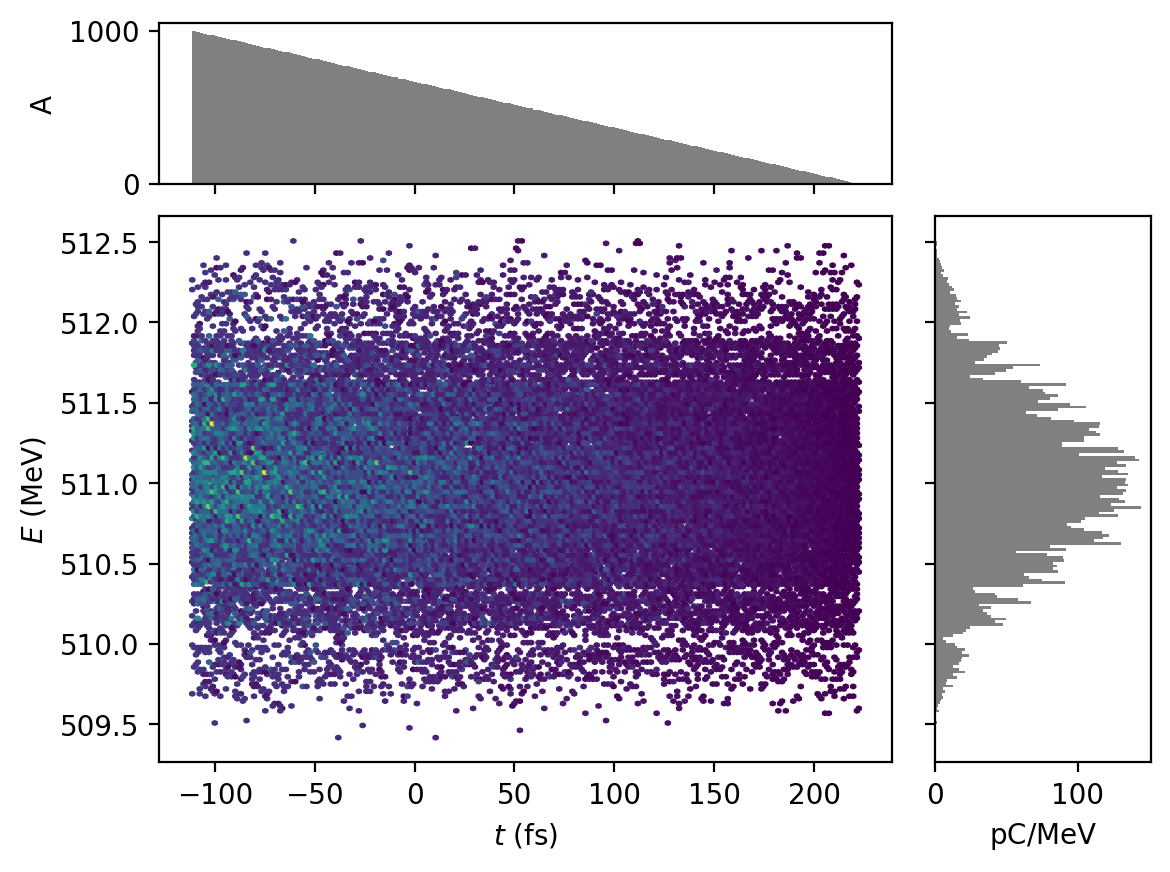

In [13]:
output.load_particles()
P1 = output.particles["end"]
P1.drift_to_z()
P1.plot("t", "energy")
P1

Resample particles for equal weights. This is neccessary when reading from a distribution file.

<ParticleGroup with 128000 particles at 0x14da395e0>

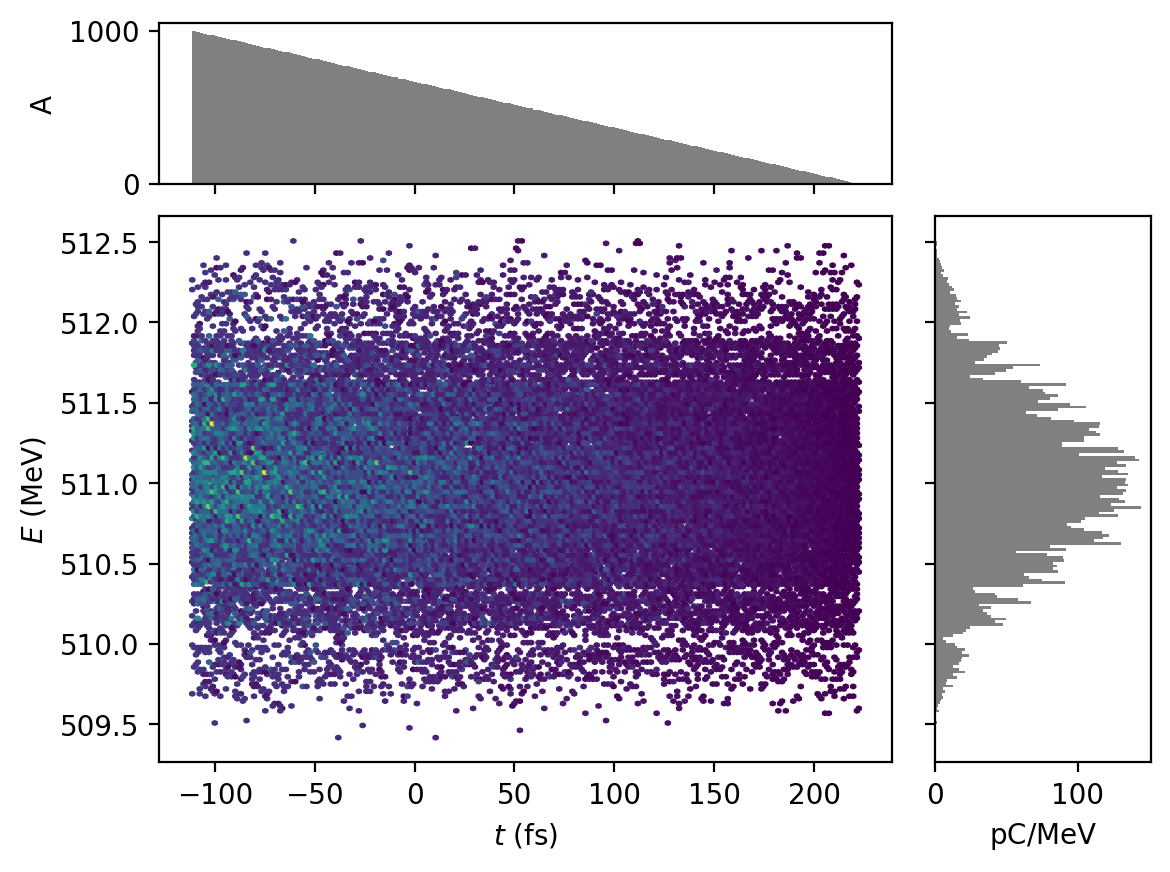

In [14]:
NSAMPLE = len(P1)
P1r = P1.resample(NSAMPLE)
P1r.plot("t", "energy")
P1r

Make a more interesting distribution from this:

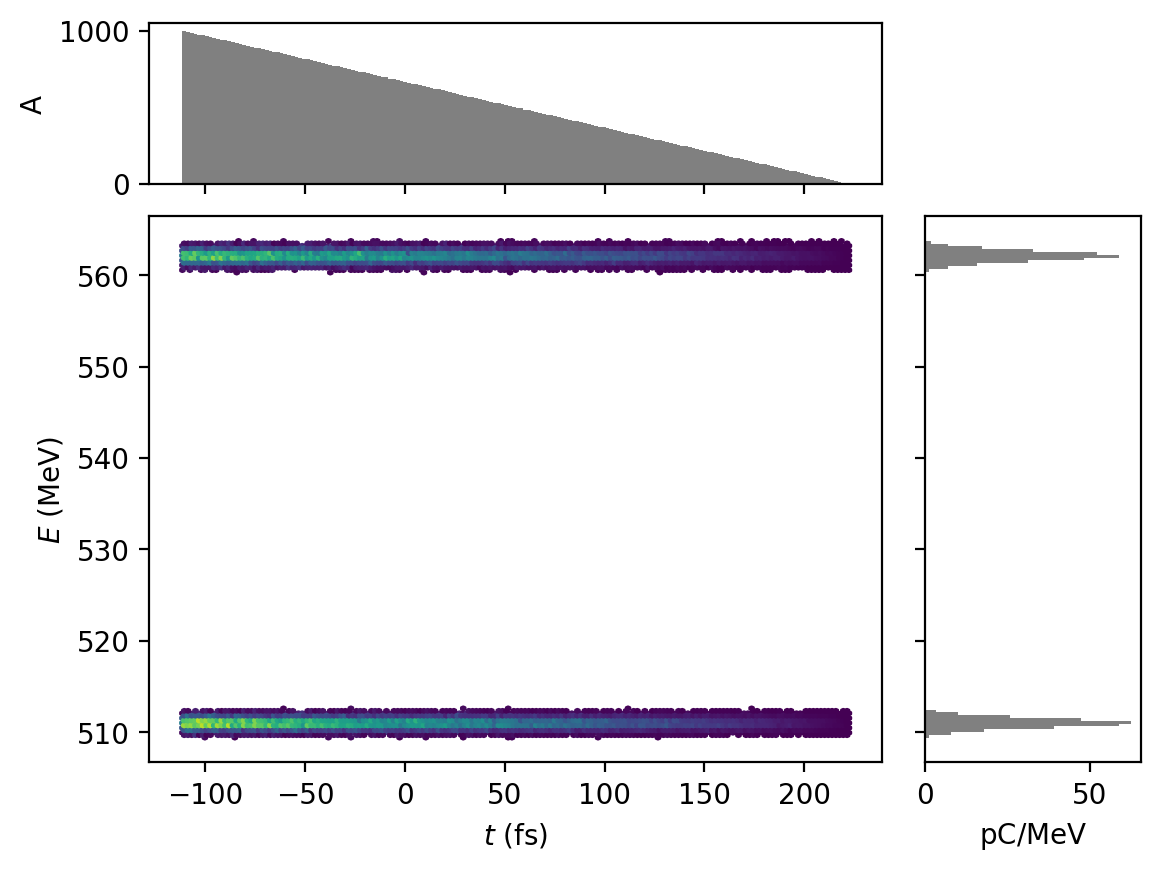

In [15]:
P1r.pz[0 : len(P1) // 2] *= 1.1
P1r.plot("t", "energy")

ParticleGroup can write to a file for Genesis4.

In [16]:
DIST_FILE = "genesis4_distribution.h5"
P1r.write_genesis4_distribution(DIST_FILE, verbose=True)

Resampling 128000 weighted particles
Datasets x, xp, y, yp, t, p written to: genesis4_distribution.h5


# InitialParticles

Use this file as the input to a new simulation. 

When using the lume-genesis-specific `InitialParticles` namelist, the appropriate input will be written automatically. 
Be sure to add it before the first "Track" or "Write" namelist in the main input.

In [17]:
from genesis.version4.input import InitialParticles

initial_particles = InitialParticles(particles=P1r)

main = MainInput(
    namelists=[
        Setup(
            rootname="drift_test",
            # lattice=full_path(LATFILE),
            beamline="LAT",
            gamma0=1000,
            lambda0=1e-07,
            delz=0.026,
            seed=123456,
            npart=512,
        ),
        Time(slen=initial_particles.slen),
        initial_particles,
        Track(zstop=1),
        Write(beam="end"),
    ],
)

input = Genesis4Input(
    main=main,
    lattice=lattice,
)
G1 = Genesis4Python(input=input, verbose=True)
output = G1.run()

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpvp7btcp0
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpvp7btcp0
/Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpvp7btcp0/genesis.lat /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpvp7btcp0/input.in


In [18]:
import pprint

pprint.pprint(output.run)

RunInfo(error=False,
        run_script='/Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l '
                   '/var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpvp7btcp0/genesis.lat '
                   '/var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmpvp7btcp0/input.in',
        output_log='---------------------------------------------\n'
                   'GENESIS - Version 4.6.4 has started...\n'
                   'Compile info: Compiled by runner at 2023-12-16 00:59:36 '
                   '[UTC] from Git Commit ID: \n'
                   'Starting Time: Fri Jan 26 11:55:41 2024\n'
                   '\n'
                   'MPI-Comm Size: 1 node\n'
                   '\n'
                   "info message: adding parameter 'lattice' to &setup\n"
                   'Parsing lattice file...\n'
                   'Setting up time window of 100 microns with 1000 sample '
                   'points...\n'
                   'Importing distribution file... \n'
          

In [19]:
print(output.run.output_log)

---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Fri Jan 26 11:55:41 2024

MPI-Comm Size: 1 node

info message: adding parameter 'lattice' to &setup
Parsing lattice file...
Setting up time window of 100 microns with 1000 sample points...
Importing distribution file... 
Charge of external distribution: 1.66782e-10
Particles in external distribution: 128000
Analysing external distribution... 
Analysis of the imported distribution
   Total Bunch Length  (microns): 99.7447
   Length for Matching (microns): 99.7447
   Energy                  (MeV): 536.493
   Norm. Emittance in x (micron): 1.00624
   Norm. Emittance in y (micron): 1.00561
   Beta Function in x        (m): 10.0856
   Beta Function in y        (m): 14.9265
   Alpha Function in x          : -0.942163
   Alpha Function in y          : 1.21318
   Beam center in x     (micron): -0.0530814
   Beam c

In [21]:
output.load_particles()
P2 = output.particles["end"]
P2.z

array([1.53264371e-08, 4.37414114e-08, 7.27885251e-08, ...,
       9.99467013e-05, 9.99715365e-05, 9.99968056e-05])

<ParticleGroup with 512000 particles at 0x168b7fce0>

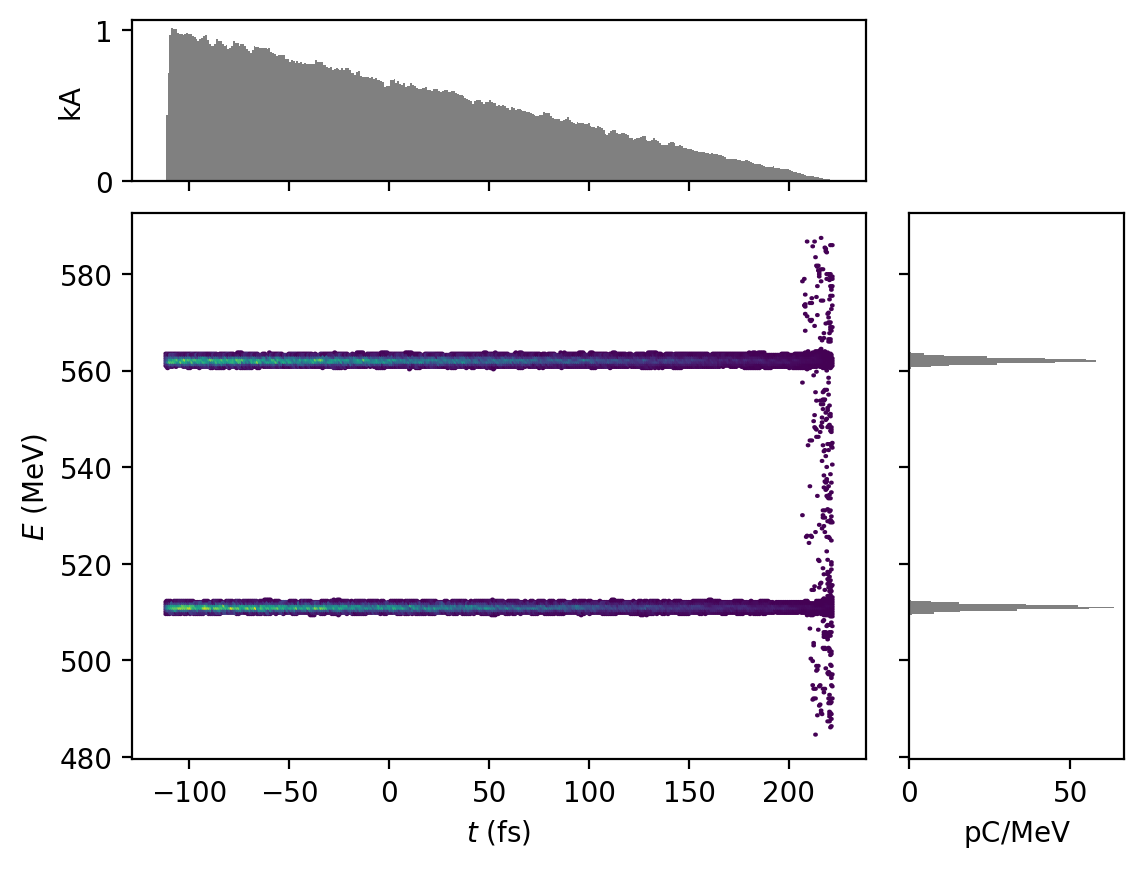

In [22]:
P2.drift_to_z()
P2.plot("t", "energy")
P2

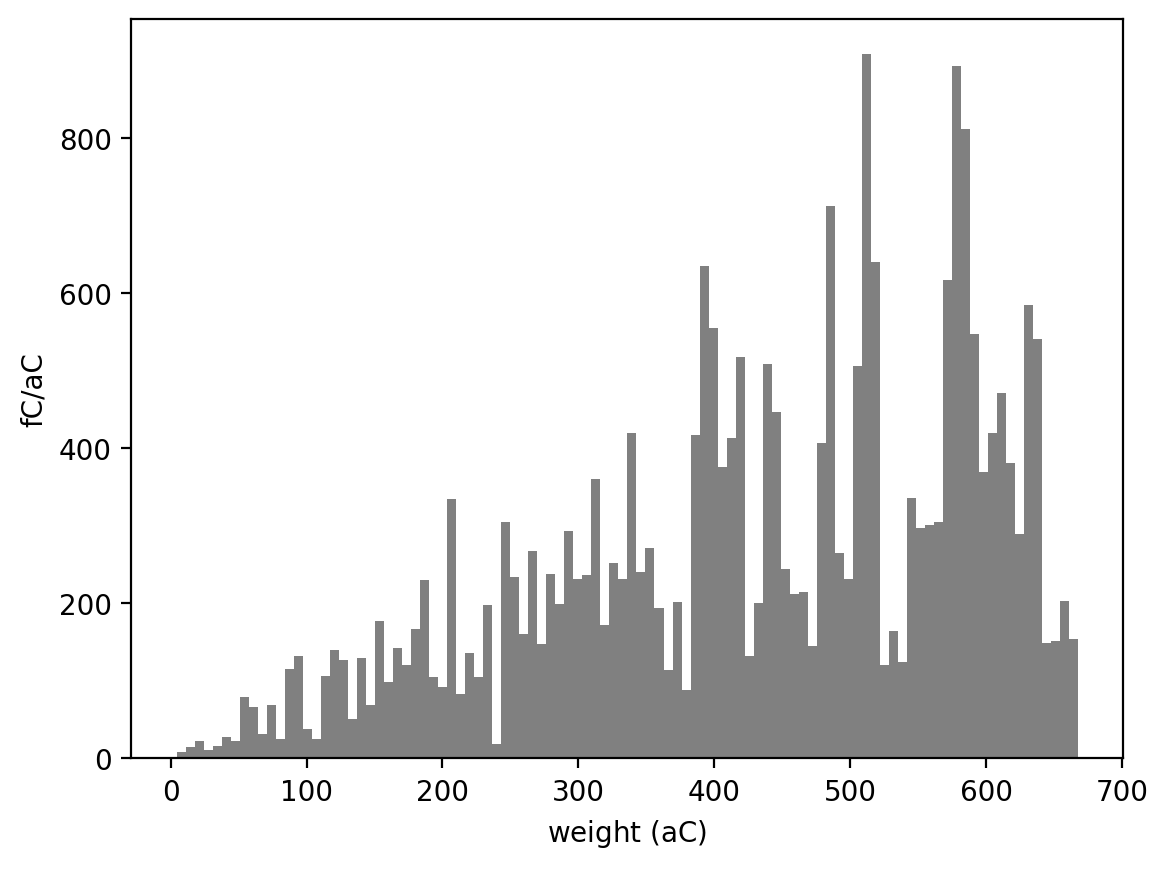

In [23]:
P2.plot("weight", bins=100)

Notice that `importdistribution` is filled in:

In [24]:
list(output.beam)

['LSCfield',
 'alphax',
 'alphay',
 'betax',
 'betay',
 'bunching',
 'bunchingphase',
 'current',
 'efield',
 'emax',
 'emin',
 'emitx',
 'emity',
 'energy',
 'energyspread',
 'pxmax',
 'pxmin',
 'pxposition',
 'pymax',
 'pymin',
 'pyposition',
 'wakefield',
 'xmax',
 'xmin',
 'xposition',
 'xsize',
 'ymax',
 'ymin',
 'yposition',
 'ysize']

In [25]:
G1.input

Genesis4Input(main=MainInput(namelists=[Setup(rootname='drift_test',
    beamline='LAT',
    gamma0=1000,
    lambda0=1e-07,
    delz=0.026,
    seed=123456,
    npart=512), Time(slen=9.999850899316347e-05), InitialParticles(particles=<ParticleGroup with 128000 particles at 0x14da395e0>, _filename='InitialParticles_0.h5'), Track(zstop=1), Write(beam='end')], filename=None), lattice=Lattice(elements={"D1": Drift(L=1, label='D1'),
    "LAT": Line(elements=[Drift(L=1, label='D1')],
    label='LAT')}), beamline=None, lattice_name=None, seed=None, source_path=PosixPath('.'), output_path=None, lattice_filename='genesis.lat', input_filename='input.in')

# Cleanup

In [26]:
os.remove(DIST_FILE)